In [1]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [1]:
conda info --env

# conda environments:
#
Amber21                  /home/sqs/.conda/envs/Amber21
dolores                  /home/sqs/.conda/envs/dolores
gmx-mmpbsa               /home/sqs/.conda/envs/gmx-mmpbsa
                         /home/sqs/amber24_src/build/CMakeFiles/miniconda/install
base                  *  /opt/miniconda3
DeepPROTACs              /opt/miniconda3/envs/DeepPROTACs
PyAutoFEP                /opt/miniconda3/envs/PyAutoFEP
af2                      /opt/miniconda3/envs/af2
karmadock                /opt/miniconda3/envs/karmadock
pytorch                  /opt/miniconda3/envs/pytorch
reinvent.v3.2            /opt/miniconda3/envs/reinvent.v3.2


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from collections import defaultdict, Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split, Subset
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random
from albumentations import Compose, HueSaturationValue, GaussianBlur, ShiftScaleRotate, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, Normalize, ElasticTransform, ColorJitter, BboxParams
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from copy import deepcopy
import matplotlib.patches as patches
import torchvision.transforms as T
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
import yaml


/home/sqs/.conda/envs/dolores/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
os.getcwd()

'/home/sqs/dolores'

## 1. Data Preprocessing
- Our dataset is from ScienceDB (scidb.cn), the url is : https://www.scidb.cn/en/s/6bq2M3</br>

- Datasets are in PASCAL VOC format</br>
- To facilitate uniform data reading, we point the current working directory to `/root` </br>
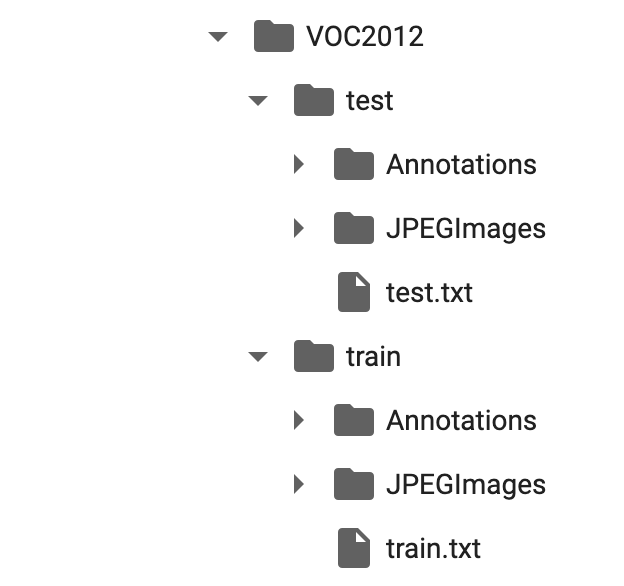

In [13]:
# convert annotation files to find How many labels are there
# Define the labels to be ignored
ignored_labels = {'mining waste', 'industry waste'}

def convert_annotation_find_labels(path, txt_file_path):
  labels = []

  with open(txt_file_path, 'r') as f:
      image_prefixes = f.read().strip().splitlines()
  updated_prefixes = []

  for each_xml in os.listdir(path):
      pic_xml = os.path.join(path, each_xml)
      tree = ET.parse(pic_xml)
      root = tree.getroot()
      objects = root.findall('object')

      # Filter out ignored tags
      objects_to_remove = [obj for obj in objects if obj.find('name').text in ignored_labels]
      for obj in objects_to_remove:
          root.remove(obj)

      # If there are no objects remaining, delete the corresponding image and comment files
      if not root.findall('object'):
          # Get image file name
          image_id = each_xml[:-4]  # Remove the .xml suffix
          img_path = os.path.join(path.replace('Annotations', 'JPEGImages'), image_id + '.jpg')

          # dele image files
          if os.path.exists(img_path):
              os.remove(img_path)
          # dele xml files
          os.remove(pic_xml)
      # Remove from the list of txt file prefixes
          if image_id in image_prefixes:
              image_prefixes.remove(image_id)
      else:
          # If there are remaining objects, save the modified comment file
          tree.write(pic_xml)

          # Collect the remaining labels
          for ele in root.findall('object'):
              label = ele.find('name').text
              labels.append(label)

          # Preserve valid image prefixes
          image_id = each_xml[:-4]
          if image_id in image_prefixes:
              updated_prefixes.append(image_id)

  # Update and save the new prefix list to a txt file
  with open(txt_file_path, 'w') as f:
    f.write('\n'.join(updated_prefixes))

  set_labels = set(labels)
  print(path, set_labels)
  return labels

train_object_labels = convert_annotation_find_labels('VOC2012/train/Annotations', 'VOC2012/train/train.txt')
test_object_labels = convert_annotation_find_labels('VOC2012/test/Annotations', 'VOC2012/test/test.txt')

VOC2012/train/Annotations {'agriculture forestry', 'disposed garbage', 'construction waste', 'domestic garbage'}
VOC2012/test/Annotations {'disposed garbage', 'construction waste', 'agriculture forestry', 'domestic garbage'}


In [14]:
with open('./label_map.json', 'r') as json_file:
  label_map = json.load(json_file)
label_name = {v : k for k, v in label_map.items()}

In [15]:
# Number of statistics for each label
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_labels):
  name_number[label_map[class_name]] += 1
  train_object_labels[index] = label_map[class_name]
# print('train_object_labels', train_object_labels)

In [16]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()), name="train_labels_distribution")
df

domestic garbage        2301
construction waste       581
agriculture forestry     247
disposed garbage           9
Name: train_labels_distribution, dtype: int64

## 1.2 Calculation of category weights based on imbalances

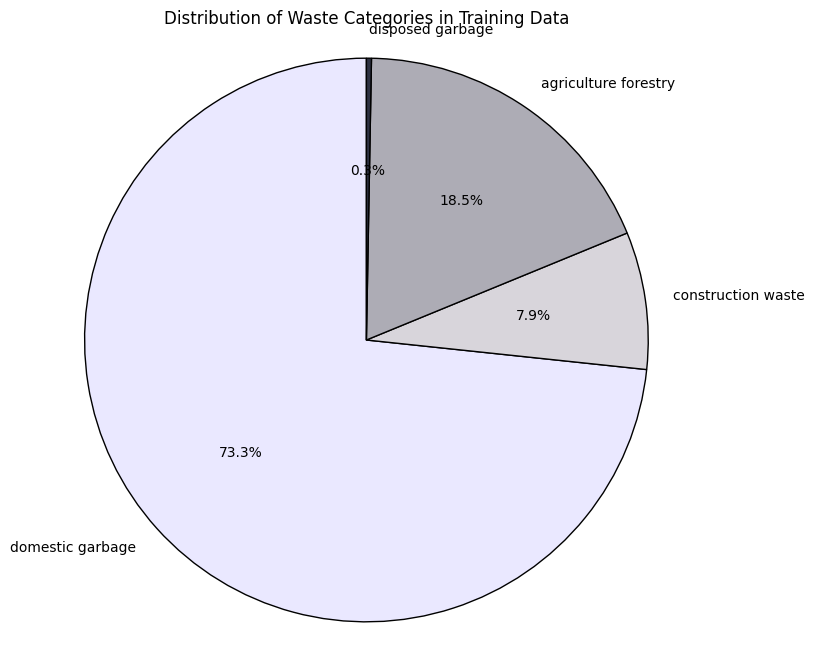

In [17]:
# Percentage of each category of visualization
# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: to make the pie chart bigger

plt.pie([2301, 247, 581, 9],
    labels=list(label_name[name] for name in name_number.keys()),
    autopct='%1.1f%%',  # Display percentage with one decimal place
    startangle=90,      # Rotate the start of the pie chart
    wedgeprops={'edgecolor': 'black'},  # Add border to slices for clarity
    colors=['#EAE8FF','#D8D5DB','#ADACB5','#2D3142', '#B0D7FF', '#FFB3E6'])  # Custom colors

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title (Optional)
plt.title('Distribution of Waste Categories in Training Data')

# Show the pie chart
plt.show()


In [18]:
def check_image_annotation_consistency(image_dir, annotation_dir):
    """
    Checks for consistency between image and annotation files in specified directories.
    
    Args:
        image_dir (str): Directory path containing image files.
        annotation_dir (str): Directory path containing annotation files.
    
    Output:
        Prints:
            - Any missing images or annotations, showing the base names without corresponding files.
            - Confirmation if all images and annotations match.
    """
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(image_dir)])
    annotation_files = set([os.path.splitext(f)[0] for f in os.listdir(annotation_dir)])

    missing_images = annotation_files - image_files
    missing_annotations = image_files - annotation_files

    if missing_images:
        print(f"Missing images for annotations: {missing_images}")
    if missing_annotations:
        print(f"Missing annotations for images: {missing_annotations}")
    if not missing_images and not missing_annotations:
        print("All images and annotations are consistent.")

# Checking the consistency of the training and test sets
check_image_annotation_consistency('VOC2012/train/JPEGImages', 'VOC2012/train/Annotations')
check_image_annotation_consistency('VOC2012/test/JPEGImages', 'VOC2012/test/Annotations')

All images and annotations are consistent.
All images and annotations are consistent.


## 1.3 Data Processing

As shown in the figure above, due to the uneven distribution of each category in the training set, it will lead to unfair training results, so we use data enhancement, category weight adjustment, and oversampling to make the proportion of images in each category reach a relative balance
- Data augmentation: data augmentation (rotation, translation, scaling, etc.) is applied to small categories to expand the sample size.
- **Category** weighting: assign larger weights to small categories during training to reduce the impact of category imbalance on the model.




In [19]:
def save_augmented_annotation(xml_path, boxes, labels, output_annotation_path):
  """
  Saves the enhanced annotation information.
    :param xml_path: path to the original XML file
    :param boxes: list of enhanced bounding boxes
    :param labels: list of enhanced labels
    :param output_annotation_path: path to the output XML file
  """
  # Parsing Raw XML Files
  tree = ET.parse(xml_path)
  root = tree.getroot()

  # Remove old object nodes (original bounding box and label information)
  for obj in root.findall("object"):
    root.remove(obj)

  # Creates a new object node based on the enhanced bounding box and label information.
  for label, box in zip(labels, boxes):
    obj = ET.SubElement(root, "object")
    name = ET.SubElement(obj, "name")
    name.text = str(label)  # Use mapped label names

    bndbox = ET.SubElement(obj, "bndbox")
    xmin = ET.SubElement(bndbox, "xmin")
    xmin.text = str(int(box[0]))  # x_min 
    ymin = ET.SubElement(bndbox, "ymin")
    ymin.text = str(int(box[1]))  # y_min
    xmax = ET.SubElement(bndbox, "xmax")
    xmax.text = str(int(box[2]))  # x_max 
    ymax = ET.SubElement(bndbox, "ymax")
    ymax.text = str(int(box[3]))  # y_max 

  # Save the updated XML to the output path
  tree.write(output_annotation_path, encoding="utf-8", xml_declaration=True)

In [20]:
class GarbageDataset(Dataset):
  def __init__(self, root, mode, output_dir=None, transforms=None, split_ratio=0.2, shuffle=True):
    self.root = root
    self.mode = mode
    self.transforms = transforms
    self.image_dir = os.path.join(root, 'JPEGImages')
    self.annotation_dir = os.path.join(root, 'Annotations')
    self.output_image_dir = os.path.join(output_dir, mode, "JPEGImages")  # transform image saved directories
    self.output_annotation_dir = os.path.join(output_dir, mode, 'Annotations')  # transform annotation saved 
    self.mode = mode

    # If output_dir is specified and the directory does not exist, create the directory
    # Create output directories if they don't exist
    os.makedirs(self.output_image_dir, exist_ok=True)
    os.makedirs(self.output_annotation_dir, exist_ok=True)

    # Load image IDs from text file
    if mode == 'train':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'valid':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'test':
      text_file = os.path.join(root, 'test.txt')
    else:
      raise ValueError("Invalid mode. Use 'train', 'valid', or 'test'.")

    with open(text_file, 'r') as f:
      self.img_ids = f.read().strip().split()

  def __len__(self):
        return len(self.img_ids)

  def __getitem__(self, index):
    """
    Retrieves and processes an image and its associated bounding boxes and labels by index.

    Args:
        index (int): Index of the image and annotations to retrieve.

    Returns:
        dict: A dictionary containing:
            - 'image' (Tensor): The processed and potentially transformed image.
            - 'boxes' (Tensor): Tensor of bounding box coordinates in [xmin, ymin, xmax, ymax] format.
            - 'labels' (Tensor): Tensor of label IDs corresponding to the objects in the image.
    """
    # Retrieve the image ID based on the index and form paths for image and annotation files
    img_id = self.img_ids[index]
    img_path = os.path.join(self.image_dir, img_id + '.jpg')
    annotation_path = os.path.join(self.annotation_dir, img_id + '.xml')
      
    # Load the image and convert it to an RGB NumPy array
    img = np.array(Image.open(img_path).convert('RGB'))

    # Parse the XMl annotation files
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Initialize lists for bounding boxes and labels
    boxes = []
    labels = []
    count = 0 # Initialize a counter to track processed samples for logging

    # Iterate over each obj in the XML files
    for obj in root.findall('object'):
        
        label = obj.find('name').text
        labels.append(label_map[label])
        
        # Extract bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Create a list for the bounding box coordinates
        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
        
    # Convert lists to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    # Prepare the final target dictionary containing bounding boxes and labels
    target = {
        "boxes": boxes,
        "labels": labels
    }

    if self.mode == "train":
        while True:
            count += 1
            
            img_copy, target_copy = img.copy(), target.copy()
            transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
            img_copy = transformed['image']
            target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
            if torch.numel(target_copy['boxes']) > 0:
                img, target = img_copy, target_copy
                break
    # For validation/testing, only apply basic transformations without augmentation
    else:
        img = self.transforms(img)
        count += 1
        
    if self.output_image_dir and self.output_annotation_dir:
        output_img_path = os.path.join(self.output_image_dir, img_id + ".jpg")
        processed_image = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert to uint8 and back to RGB
        cv2.imwrite(output_img_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))
        
        # Save the augmented XML annotation
        output_annotation_path = os.path.join(self.output_annotation_dir, img_id + '.xml')
        save_augmented_annotation(annotation_path, target['boxes'].tolist(), target['labels'].tolist(), output_annotation_path)
        tree.write(output_annotation_path, encoding='utf-8', xml_declaration=True)
    
    if count % 100 == 0:
        print(f'prcossing: {count}')
    return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}
  def load_annotations(self):
    """
    The load_annotations function retrieves the class labels present in each image. This information can be used to
    dynamically adjust the weighting of each image during training based on class occurrence.

    Returns:
        list : A list of lists, where each sublist contains the labels found in a specific image.
    """
    data_infos = []
    for idx, index in enumerate(self.img_ids):
        ann_path = os.path.join(self.annotation_dir, index + '.xml')
        tree = ET.parse(ann_path)
        root = tree.getroot()
        temp_labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            temp_labels.append(label_map[label])
        data_infos.append(temp_labels)

      # Move the print inside the loop to print each image's data as it's processed
        if idx % 100 == 0:
            print(f'data_infos ({self.mode}): Image {idx + 1}/{len(self.img_ids)} processed - {index}')
    return data_infos



In [21]:
transform = {
    "train" : Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=180, p=0.5),  
        ShiftScaleRotate(scale_limit=0.5, rotate_limit=15, p=0.5), \
        RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.3),  # Optional color enhancement
        GaussianBlur(blur_limit=(3, 5), p=0.2),  # Optional blur enhancement
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=BboxParams(format='pascal_voc', label_fields=['labels'])),
    "test" : T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

## 1.4 Split Train Dataset to train dataset and valitation dataset

In [26]:
# train_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])
# val_dataset = GarbageDataset(root='VOC2012/train', mode='valid', output_dir='./new_dumpsite_data', transforms=transform["test"])
# test_dataset = GarbageDataset(root='VOC2012/test', mode='test', output_dir='./new_dumpsite_data', transforms=transform["test"])

# def create_subsets(dataset, validation_split=0.2):
#     torch.manual_seed(42)
#     np.random.seed(42)
#     dataset_size = len(dataset)
#     validation_size = int(validation_split * dataset_size)
#     train_size = dataset_size - validation_size
#     train_indices, val_indices = random_split(range(dataset_size), [train_size, validation_size])
#     return Subset(dataset, train_indices), Subset(dataset, val_indices)

# train_subset, val_subset = create_subsets(train_dataset)

# def collate_fn(batch):
#     images = []
#     targets = []
#     for obj in batch:
#         if obj:
#             images.append(obj['image'])
#             targets.append({'boxes':obj['boxes'], 'labels':obj['labels']})
#     images = torch.stack(images, dim=0)
#     return images, targets

# def calculate_class_weights(dataset, subset_indices, epsilon=0.01, method='log', small_class_boost=2.0):
#     n_c = defaultdict(int)
#     for idx in subset_indices:
#         labels = dataset[idx]['labels']
#         # mul labels
#         for label in labels:
#             n_c[int(label.item())] += 1
#     if method == "log":
#         class_weights = {key: 1.0 / (np.log(value + 1) + epsilon) for key, value in n_c.items()}
#     elif method == "square":
#         class_weights = {key: 1.0 / (value ** 2 + epsilon) for key, value in n_c.items()}
#     else:
#         class_weights = {key: 1.0 / (value + epsilon) for key, value in n_c.items()}
    
#     # Boost small classes
#     for key in n_c:
#         if n_c[key] < 500:  # Threshold can be adjusted
#             class_weights[key] *= small_class_boost
#         if n_c[key] > 2000:  # 对于频率极高的类别，减小其权重
#             class_weights[key] *= 0.5
            
#     return class_weights

# classes_weights = calculate_class_weights(train_dataset, train_subset.indices, method="linear", epsilon=0.1)


# def calculate_image_weights(annotations, classes_weights):
#     image_weights = []
#     for img_classes in annotations:
#         # img_weight = classes_weights[img_classes[0]]
#         img_weight = np.mean([classes_weights[class_id] for class_id in img_classes])
#         image_weights.append(img_weight)
#     return image_weights

# annotations = train_dataset.load_annotations()
# image_weights = calculate_image_weights(annotations, classes_weights)
# np.save('image_weights.npy', np.array(image_weights))
# print('Saved image_weight.npy successfully')

# train_image_weights = [image_weights[i] for i in train_subset.indices]
# # sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=len(train_image_weights), replacement=True)
# sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=int(len(train_image_weights) * 1.5), replacement=True)

# train_dataloader = DataLoader(train_subset, batch_size=32, collate_fn=collate_fn, sampler=sampler)
# val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
# test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)


# Initial the original dataset
full_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])
test_dataset = GarbageDataset(root='VOC2012/test', mode='test', output_dir='./new_dumpsite_data', transforms=transform["test"])


def create_stratified_subsets(dataset, validation_split=0.2):
    torch.manual_seed(42)
    np.random.seed(42)

    # Extract labels and create binary encoding
    labels = [dataset[i]['labels'] for i in range(len(dataset))]
    unique_labels = sorted(set(label for sublist in labels for label in sublist))

    # Create a binary encoding matrix for multi-label stratification
    binary_labels = np.zeros((len(dataset), len(unique_labels)), dtype=int)
    for idx, label_list in enumerate(labels):
        for label in label_list:
            binary_labels[idx][unique_labels.index(label.item())] = 1

    # Convert binary matrix to a single label per sample for stratification
    # This combines multi-labels into a single label that represents the unique pattern
    stratify_labels = np.dot(binary_labels, range(1, len(unique_labels) + 1))

    # Use StratifiedShuffleSplit for stratified sampling
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=validation_split, random_state=42)
    for train_idx, val_idx in stratified_split.split(np.zeros(len(stratify_labels)), stratify_labels):
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

    return train_subset, val_subset



# Usage
train_subset, val_subset = create_stratified_subsets(full_dataset)

def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        if obj:
            images.append(obj['image'])
            targets.append({'boxes': obj['boxes'], 'labels': obj['labels']})
    images = torch.stack(images, dim=0)
    return images, targets

def calculate_class_weights(dataset, subset_indices, epsilon=0.01, method='log', small_class_boost=2.0):
    n_c = defaultdict(int)
    for idx in subset_indices:
        labels = dataset[idx]['labels']
        for label in labels:
            n_c[int(label.item())] += 1
    if method == "log":
        class_weights = {key: 1.0 / (np.log(value + 1) + epsilon) for key, value in n_c.items()}
    elif method == "square":
        class_weights = {key: 1.0 / (value ** 2 + epsilon) for key, value in n_c.items()}
    else:
        class_weights = {key: 1.0 / (value + epsilon) for key, value in n_c.items()}

    # Boost small classes
    for key in n_c:
        if n_c[key] < 500:  # Threshold can be adjusted
            class_weights[key] *= small_class_boost
        if n_c[key] > 2000:  # Reduce weight for very frequent classes
            class_weights[key] *= 0.5

    return class_weights

# Calculate class weights based on the training subset
classes_weights = calculate_class_weights(full_dataset, train_subset.indices, method="linear", epsilon=0.1)

def calculate_image_weights(annotations, classes_weights):
    image_weights = []
    for img_classes in annotations:
        # img_weight = classes_weights[img_classes[0]]
        img_weight = np.mean([classes_weights[class_id] for class_id in img_classes])
        image_weights.append(img_weight)
    return image_weights

# Load annotations from the full dataset
annotations = full_dataset.load_annotations()
image_weights = calculate_image_weights(annotations, classes_weights)
np.save('image_weights.npy', np.array(image_weights))
print('Saved image_weight.npy successfully')


# Retrieve image weights for the train subset
train_image_weights = [image_weights[i] for i in train_subset.indices]
sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=int(len(train_image_weights) * 1.5), replacement=True)

# Create dataloaders
train_dataloader = DataLoader(train_subset, batch_size=32, collate_fn=collate_fn, sampler=sampler)
val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)


def check_one_epoch_label(dataloader):
    one_epoch_label_number = defaultdict(int)
    count = 0
    for images, targets in dataloader:
        for target in targets:
            labels = target["labels"].numpy()
            for label in labels:
                one_epoch_label_number[label] += 1
        count += 1
    if count % 100 == 0:
        print('processing: ', count)
    print("One Epoch Label Distribution:", one_epoch_label_number)

# Run the check_one_epoch_label to see label distribution in one epoch
print("Training Set Label Distribution:")
check_one_epoch_label(train_dataloader)

print("Validation Set Label Distribution:")
check_one_epoch_label(val_dataloader)


data_infos (train): Image 1/2669 processed - N90113
data_infos (train): Image 101/2669 processed - N00089
data_infos (train): Image 201/2669 processed - 20189
data_infos (train): Image 301/2669 processed - LN15544
data_infos (train): Image 401/2669 processed - N00097
data_infos (train): Image 501/2669 processed - 20209
data_infos (train): Image 601/2669 processed - 60374
data_infos (train): Image 701/2669 processed - N90155
data_infos (train): Image 801/2669 processed - 20066
data_infos (train): Image 901/2669 processed - N00172
data_infos (train): Image 1001/2669 processed - LN9664
data_infos (train): Image 1101/2669 processed - 20196
data_infos (train): Image 1201/2669 processed - 60442
data_infos (train): Image 1301/2669 processed - N00457
data_infos (train): Image 1401/2669 processed - 60212
data_infos (train): Image 1501/2669 processed - N90062
data_infos (train): Image 1601/2669 processed - CS11844
data_infos (train): Image 1701/2669 processed - N00259
data_infos (train): Image 1

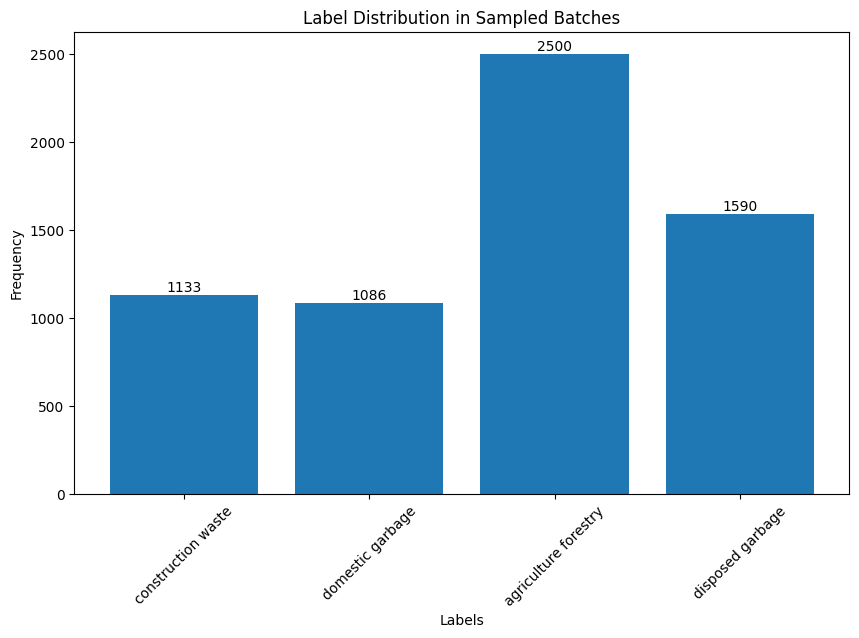

In [47]:
def plot_label_distribution(dataloader, label_map):
    # Distribution of statistical labels
    label_counts = defaultdict(int)

    # Iterate through batches and count labels
    for batch in dataloader:
        for labels in batch[1]: 
            for label in labels['labels']:
                label_counts[label.item()] += 1

    labels, counts = zip(*label_counts.items())
    labels = [list(label_map.keys())[list(label_map.values()).index(lab)] for lab in labels]  

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title("Label Distribution in Sampled Batches")

    # Add counts above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Display count

    plt.show()

plot_label_distribution(train_dataloader, label_map)

Training Set Label Distribution:


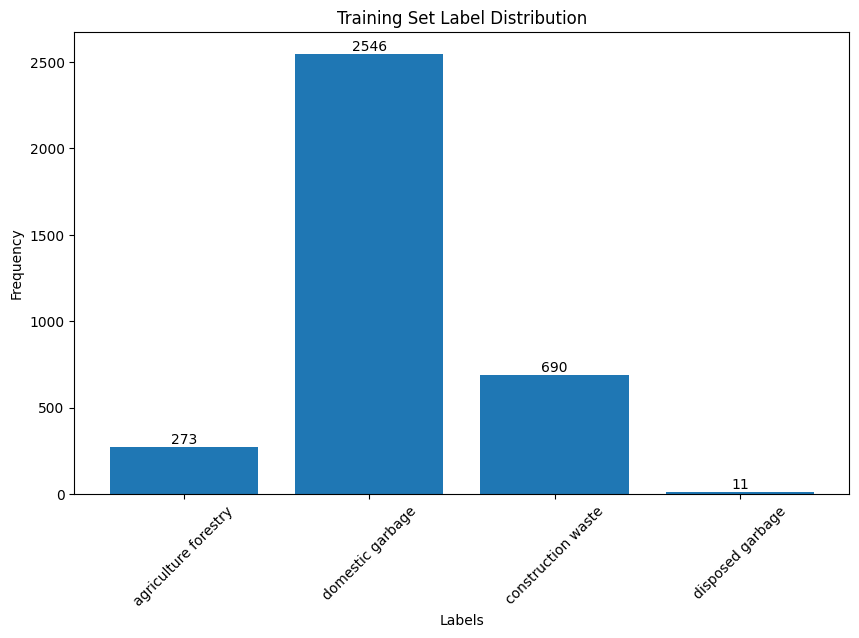

In [48]:
# Visualize label distribution for each subset
def plot_label_distribution(dataset, label_map, title="Label Distribution"):
    # Create a dictionary to count each label's occurrence
    label_counts = defaultdict(int)
    for idx in range(len(dataset)):
        sample = dataset[idx]
        for label in sample['labels'].tolist():  # convert to list to iterate
            label_counts[label] += 1

    # Convert label counts to names
    labels, counts = zip(*label_counts.items())
    label_names = [list(label_map.keys())[list(label_map.values()).index(lab)] for lab in labels]

    # Plot distribution
    plt.figure(figsize=(10, 6))
    bars = plt.bar(label_names, counts)
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title(title)

    # Add counts above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()
# Assuming `label_map` is a dictionary mapping label names to IDs
print("Training Set Label Distribution:")
plot_label_distribution(train_subset, label_map, title="Training Set Label Distribution")

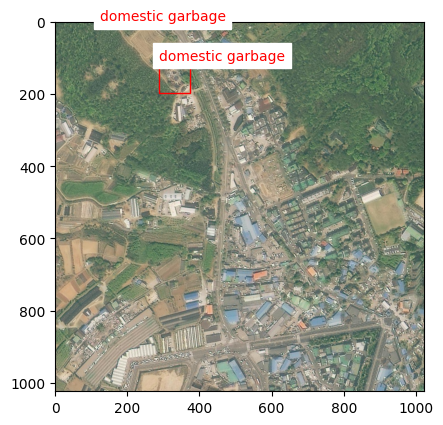

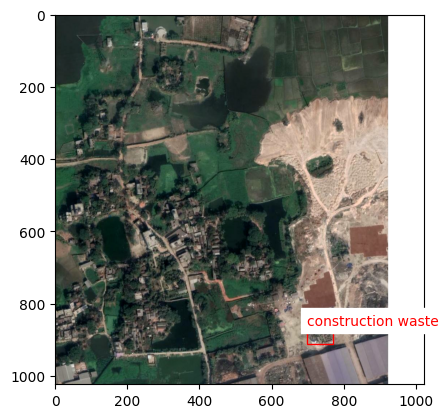

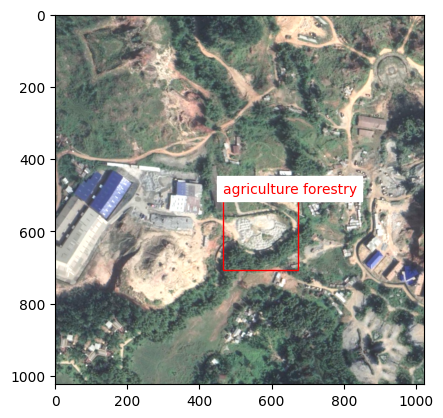

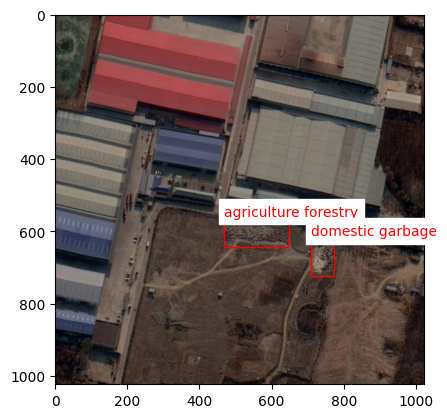

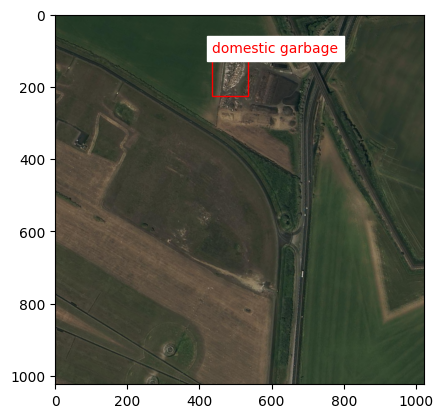

In [15]:
def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  mean = torch.tensor(mean)[:, None, None]
  std = torch.tensor(std)[:, None, None]
  return image * std + mean

# Functions for visualizing images and their bounding boxes
def visualize_sample(image, boxes, labels, label_map):
  fig, ax = plt.subplots(1)
  # Normalize image to the range [0, 1]
  image = unnormalize(image).permute(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
  image = image / 255.0 if image.dtype == torch.uint8 else image.clip(0, 1)

  ax.imshow(image)

  for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, label_map[label.item()], color='red', fontsize=10, backgroundcolor="white")

  plt.show()

batch_size = 1  # Load one image at a time
subset_size = 5  # Take 5 images for testing

# load and test
subset_indices = list(range(subset_size))  # Get indices of the first 5 images
subset = Subset(train_dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False)


for batch in dataloader:
  image, boxes, labels = batch['image'][0], batch['boxes'][0], batch['labels'][0]
  visualize_sample(image, boxes, labels, label_name)


## 2. Model Part
## 2.1 Model one: [YOLOV8](https://github.com/ultralytics/ultralytics)

In [27]:
# Define directories
project_root = 'yolo'
data_dir = os.path.join(project_root, 'dataset')
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

train_xml_dir = 'new_dumpsite_data/train/Annotations'
val_xml_dir = 'new_dumpsite_data/valid/Annotations'
test_xml_dir = 'new_dumpsite_data/test/Annotations'

train_img_src_dir = 'new_dumpsite_data/train/JPEGImages'
val_img_src_dir = 'new_dumpsite_data/valid/JPEGImages'
test_img_src_dir = 'new_dumpsite_data/test/JPEGImages'

yolo_train_img_src_dir = os.path.join(images_dir, 'train')
yolo_val_img_src_dir = os.path.join(images_dir, 'val')
yolo_test_img_src_dir = os.path.join(images_dir, 'test')


In [28]:
def create_yolo_directory_structure(base_dir='yolo_dataset'):
    # Paths for YOLO directory structure
    dirs = {
        'train_images': os.path.join(base_dir, 'images', 'train'),
        'val_images': os.path.join(base_dir, 'images', 'val'),
        'test_images': os.path.join(base_dir, 'images', 'test'),
        'train_labels': os.path.join(base_dir, 'labels', 'train'),
        'val_labels': os.path.join(base_dir, 'labels', 'val'),
        'test_labels': os.path.join(base_dir, 'labels', 'test')
    }
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    return dirs

def save_yolo_labels(dataloader, output_image_dir, output_label_dir):
    transform = transforms.ToPILImage()  # Create a transform to convert tensors to PIL images
    for batch_idx, (images, targets) in enumerate(dataloader):
        for i, (image, target) in enumerate(zip(images, targets)):
            img_id = f"{batch_idx}_{i}"
            # Convert tensor to PIL Image
            pil_image = transform(image)

            # Save image
            img_save_path = os.path.join(output_image_dir, f"{img_id}.jpg")
            pil_image.save(img_save_path)

            # Convert bounding boxes to YOLO format and save to label file
            label_save_path = os.path.join(output_label_dir, f"{img_id}.txt")
            with open(label_save_path, 'w') as f:
                for bbox, class_id in zip(target['boxes'], target['labels']):
                    # YOLO format: class_id, x_center, y_center, width, height
                    x_min, y_min, x_max, y_max = bbox.tolist()
                    img_width, img_height = image.shape[2], image.shape[1]

                    # Normalize bounding box coordinates
                    x_center = (x_min + x_max) / 2 / img_width
                    y_center = (y_min + y_max) / 2 / img_height
                    width = (x_max - x_min) / img_width
                    height = (y_max - y_min) / img_height

                    # Write each annotation to file
                    f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Directory paths for YOLO dataset
dirs = create_yolo_directory_structure()

# Save labels and images for train, validation, and test dataloaders
save_yolo_labels(train_dataloader, dirs['train_images'], dirs['train_labels'])
save_yolo_labels(val_dataloader, dirs['val_images'], dirs['val_labels'])
save_yolo_labels(test_dataloader, dirs['test_images'], dirs['test_labels'])

# Create the dataset.yaml file
dataset_yaml = {
    'train': os.path.abspath(dirs['train_images']),
    'val': os.path.abspath(dirs['val_images']),
    'test': os.path.abspath(dirs['test_images']),
    'nc': len(label_map),
    'names': list(label_map.values())
}

# Save dataset.yaml
with open(os.path.join('yolo_dataset', 'dataset.yaml'), 'w') as f:
    yaml.dump(dataset_yaml, f)

print("YOLO dataset structure created successfully.")

YOLO dataset structure created successfully.


In [23]:
# Check the labels distribution in yolo
def check_yolo_label(labels_dir, mode):
    label_counter = Counter()
    
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(labels_dir, filename), 'r') as f:
                for line in f:
                    # Each line in the YOLO format starts with a category number
                    class_id = line.split()[0]  
                    label_counter[class_id] += 1
    
    for class_id, count in label_counter.items():
        print(f'{mode}: Class ID: {class_id}, Count: {count}')

train_label = check_yolo_label('yolo/dataset/labels/train', 'train')
val_label = check_yolo_label('yolo/dataset/labels/val', 'val')
test_label = check_yolo_label('yolo/dataset/labels/test', 'test')


train: Class ID: 0, Count: 1986
train: Class ID: 3, Count: 518
train: Class ID: 1, Count: 229
train: Class ID: 2, Count: 9
val: Class ID: 0, Count: 660
val: Class ID: 1, Count: 95
val: Class ID: 3, Count: 182
val: Class ID: 2, Count: 1
test: Class ID: 3, Count: 126
test: Class ID: 1, Count: 142
test: Class ID: 0, Count: 635
test: Class ID: 2, Count: 3


In [29]:
model = YOLO('yolov8n.pt')
model.train(
    data='./yolo_dataset/dataset.yaml',  # Dataset profile path
    epochs=50,                   # Number of training rounds, which can be adjusted as needed
    imgsz=640,                   # image size
    batch=16,                    # batch size, adjusted for video memory size
    name='yolo_dataset_training' # Project name, which will generate the folder where the model will be saved
    freeze=[]                    # Ensures no layers are frozen during training
)

# # Load a model
# model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)

# # Train the model
# results = model.train(data="coco8-seg.yaml", epochs=100, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.25 🚀 Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4500, 20171MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./yolo_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo_dataset_training14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

train: Scanning /home/sqs/dolores/yolo_dataset/labels/train... 4136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4136/4136 [00:


train: New cache created: /home/sqs/dolores/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/sqs/dolores/yolo_dataset/labels/val... 931 images, 0 backgrounds, 0 corrupt: 100%|██████████| 931/931 [00:02<00:0


val: New cache created: /home/sqs/dolores/yolo_dataset/labels/val.cache
Plotting labels to runs/detect/yolo_dataset_training14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo_dataset_training14
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.24G      2.298      4.169      2.076         19        640: 100%|██████████| 259/259 [00:56<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:39<00:00,  1.33s


                   all        931       1329     0.0362     0.0849     0.0156    0.00498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.18G      2.227      3.517      2.001         18        640: 100%|██████████| 259/259 [00:23<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.68i


                   all        931       1329     0.0346       0.35     0.0138    0.00469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.22G       2.21      3.255      1.996         38        640: 100%|██████████| 259/259 [00:22<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  6.63i


                   all        931       1329     0.0381     0.0777     0.0133    0.00427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.19G      2.162      3.133      1.969         14        640: 100%|██████████| 259/259 [00:27<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  7.83i


                   all        931       1329     0.0618     0.0824     0.0224    0.00786

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.2G      2.089      2.978      1.936         18        640: 100%|██████████| 259/259 [00:23<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.10i


                   all        931       1329      0.076      0.371     0.0323     0.0154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.2G      2.041      2.889       1.88         18        640: 100%|██████████| 259/259 [00:23<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.93i


                   all        931       1329      0.318      0.261     0.0679     0.0215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.2G      1.995      2.792      1.843         16        640: 100%|██████████| 259/259 [00:22<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.06i


                   all        931       1329       0.41      0.253     0.0638     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.19G       1.97        2.7      1.807         26        640: 100%|██████████| 259/259 [00:22<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.12i


                   all        931       1329     0.0715      0.414     0.0482     0.0186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.25G      1.923      2.629      1.776         23        640: 100%|██████████| 259/259 [00:22<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.79i


                   all        931       1329      0.369      0.255      0.119     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.19G      1.879      2.548      1.747         41        640: 100%|██████████| 259/259 [00:22<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.04i


                   all        931       1329     0.0838      0.264     0.0488     0.0291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.19G      1.853      2.481      1.739         19        640: 100%|██████████| 259/259 [00:22<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.57i


                   all        931       1329      0.577       0.25      0.116     0.0625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.19G      1.862      2.489      1.745         35        640: 100%|██████████| 259/259 [00:22<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.84i


                   all        931       1329      0.424      0.261      0.292      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.19G      1.809      2.395      1.698         15        640: 100%|██████████| 259/259 [00:22<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.35i


                   all        931       1329      0.698      0.261      0.135     0.0436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.19G      1.808      2.384      1.697         19        640: 100%|██████████| 259/259 [00:23<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.61i


                   all        931       1329        0.4      0.261       0.28      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.19G      1.772      2.318      1.653         34        640: 100%|██████████| 259/259 [00:22<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.77i


                   all        931       1329      0.696      0.253       0.29       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.19G      1.777       2.28      1.667         16        640: 100%|██████████| 259/259 [00:23<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.95i


                   all        931       1329      0.978       0.25       0.28      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.22G      1.735      2.226      1.632         14        640: 100%|██████████| 259/259 [00:23<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.12i


                   all        931       1329       0.84      0.253      0.313      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.17G      1.734      2.199      1.637         22        640: 100%|██████████| 259/259 [00:22<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.11i


                   all        931       1329      0.323      0.253      0.126     0.0835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.19G      1.712      2.166      1.609         23        640: 100%|██████████| 259/259 [00:22<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.65i


                   all        931       1329      0.528       0.27      0.122     0.0685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.19G      1.695      2.145      1.614         20        640: 100%|██████████| 259/259 [00:22<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.19i


                   all        931       1329      0.855      0.268      0.314      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.16G      1.679        2.1      1.578         31        640: 100%|██████████| 259/259 [00:22<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.83i


                   all        931       1329      0.655      0.261      0.138     0.0903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.19G      1.653      2.049      1.563         17        640: 100%|██████████| 259/259 [00:23<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16i


                   all        931       1329      0.777      0.253      0.209      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.22G      1.659      2.043      1.562         21        640: 100%|██████████| 259/259 [00:22<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.00i


                   all        931       1329       0.96       0.25      0.322      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.2G      1.633      2.004       1.55         14        640: 100%|██████████| 259/259 [00:22<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.05i


                   all        931       1329      0.449      0.256      0.117     0.0723

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.16G      1.612      1.969      1.546         23        640: 100%|██████████| 259/259 [00:22<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.14i


                   all        931       1329      0.767      0.264      0.336       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.19G      1.625      1.965      1.532         19        640: 100%|██████████| 259/259 [00:22<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.02i


                   all        931       1329      0.843      0.274      0.332       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.17G      1.613      1.948      1.538         19        640: 100%|██████████| 259/259 [00:22<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.30i


                   all        931       1329      0.511      0.265      0.206      0.161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.2G      1.587      1.883      1.517         23        640: 100%|██████████| 259/259 [00:22<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  8.91i


                   all        931       1329      0.699      0.268      0.341      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.21G      1.572      1.855      1.501         16        640: 100%|██████████| 259/259 [00:22<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.37i


                   all        931       1329      0.823      0.282      0.347       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.19G      1.543      1.813      1.482         17        640: 100%|██████████| 259/259 [00:22<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.09i


                   all        931       1329      0.573       0.26      0.324      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.23G      1.537      1.791      1.471         24        640: 100%|██████████| 259/259 [00:22<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.33i


                   all        931       1329       0.39      0.342      0.168      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.2G      1.557      1.835      1.478         16        640: 100%|██████████| 259/259 [00:22<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.01i


                   all        931       1329      0.789      0.294      0.341      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.18G       1.52      1.773      1.462         22        640: 100%|██████████| 259/259 [00:22<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.23i


                   all        931       1329        0.5      0.273      0.341      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.19G      1.533      1.774      1.452         32        640: 100%|██████████| 259/259 [00:22<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:04<00:00,  7.10i


                   all        931       1329      0.443      0.327      0.185      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.2G      1.508      1.735      1.459         10        640: 100%|██████████| 259/259 [00:22<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.04i


                   all        931       1329      0.489      0.336      0.223       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.17G      1.492      1.683      1.436         26        640: 100%|██████████| 259/259 [00:23<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.19i


                   all        931       1329       0.37      0.342      0.348      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.18G      1.498      1.714      1.437         14        640: 100%|██████████| 259/259 [00:24<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.14i


                   all        931       1329      0.445      0.323      0.191      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.19G      1.473      1.671      1.428         28        640: 100%|██████████| 259/259 [00:22<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16i


                   all        931       1329      0.755      0.296      0.342      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.19G      1.462      1.645      1.422         29        640: 100%|██████████| 259/259 [00:23<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.07i


                   all        931       1329      0.822      0.272       0.34      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.19G      1.466       1.65      1.416         27        640: 100%|██████████| 259/259 [00:22<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.12i


                   all        931       1329      0.793      0.305      0.364      0.252
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.17G      1.416      1.546      1.408         12        640: 100%|██████████| 259/259 [00:22<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.22i


                   all        931       1329      0.519      0.352      0.371      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.17G      1.388      1.481      1.393         14        640: 100%|██████████| 259/259 [00:22<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.21i


                   all        931       1329        0.6      0.336      0.255      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.17G      1.376      1.452      1.385         12        640: 100%|██████████| 259/259 [00:22<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.23i


                   all        931       1329      0.505      0.347      0.239      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.17G      1.348      1.418      1.369         13        640: 100%|██████████| 259/259 [00:22<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16i


                   all        931       1329      0.448      0.369      0.254      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.17G      1.328      1.378       1.35         15        640: 100%|██████████| 259/259 [00:21<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.23i


                   all        931       1329      0.503      0.369      0.255      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.19G      1.333       1.37      1.353         12        640: 100%|██████████| 259/259 [00:22<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.16i


                   all        931       1329      0.617      0.335      0.244      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.17G      1.326      1.355      1.349         17        640: 100%|██████████| 259/259 [00:22<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.11i


                   all        931       1329      0.556      0.373      0.259      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.22G       1.31      1.322      1.341          9        640: 100%|██████████| 259/259 [00:22<00:00, 11.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.20i


                   all        931       1329       0.56      0.365      0.268      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.18G      1.309      1.337      1.338          9        640: 100%|██████████| 259/259 [00:22<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.23i


                   all        931       1329       0.57      0.365      0.254      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.17G      1.297      1.306      1.338         19        640: 100%|██████████| 259/259 [00:22<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:03<00:00,  9.20i


                   all        931       1329      0.612       0.35      0.252       0.15

50 epochs completed in 0.394 hours.
Optimizer stripped from runs/detect/yolo_dataset_training14/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolo_dataset_training14/weights/best.pt, 6.2MB

Validating runs/detect/yolo_dataset_training14/weights/best.pt...
Ultralytics 8.3.25 🚀 Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4500, 20171MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:06<00:00,  4.99i


                   all        931       1329      0.522      0.352      0.372      0.282
                     0        722        955      0.598    0.00936     0.0845     0.0326
                     1         75         94      0.469      0.319      0.242      0.131
                     2          1          1      0.373          1      0.995      0.895
                     3        186        279       0.65     0.0797      0.165      0.067
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolo_dataset_training14


/home/sqs/.conda/envs/dolores/lib/python3.11/site-packages/ultralytics/utils/plotting.py:1188: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(fname, dpi=200)


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe6cbf60490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
# verification model
metrics = model.val(data='yolo/dataset.yaml')  # Validation set metrics

# 测试模型（如果 `dataset.yaml` 中配置了测试集）
results = model.predict(source='yolo/dataset/images/test', save=True)  # 测试图像，并保存结果


Ultralytics 8.3.25 🚀 Python-3.11.9 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4500, 20171MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/sqs/dolores/yolo/dataset/labels/val.cache... 804 images, 0 backgrounds, 0 corrupt: 100%|██████████| 804/804 [00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [01:46<00:00,  2.09s


                   all        804        938      0.591      0.426      0.479      0.374
                     0        588        660      0.629     0.0129      0.111     0.0422
                     1         91         95      0.519      0.558       0.51      0.314
                     2          1          1      0.545          1      0.995      0.995
                     3        168        182      0.671      0.135      0.301      0.144
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolo_dataset_training142

